In [1]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter
from thop import profile
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from scipy import interp
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.__version__)

1.7.0+cu110


In [68]:
def train_model(model, optimizer, loss, scheduler=None, num_epoches=100, verbose=10, writer=None):
    '''
    输入
    model: 需要训练的模型
    optimizer: 优化器
    loss: 损失函数
    num_epoches: 训练次数
    verbose: 训练信息的打印间隔
    writer：训练过程记录

    输出
    model: 训练完成的模型
    accuracy_train: 训练集正确率
    accuracy_test: 测试集正确率
    '''
    model.train()
    dur = []
    lr_list = []
    for epoch in range(1, num_epoches+1):
        # if epoch >= 3:
        #     t0 = time.time()
        loss_train, n, total_acc = 0.0, 0, 0
        t0 = time.time()
        for X, y  in trainloader:
            X = X.to(device)
            y = y.to(device)
            y_pred_proba = model(X)
            l = loss(y_pred_proba, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            loss_train += l.item()
            n += y.shape[0]
            y_pred = torch.argmax(y_pred_proba, axis=1)
            total_acc += torch.sum(y==y_pred).item()
        
        lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        if scheduler:
            scheduler.step()
        dur.append(time.time() - t0)
        accuracy_train = total_acc / n
        accuracy_test, loss_test = eval_test(model, loss)

        if writer:
            writer.add_scalar('Loss/Train', loss_train, epoch)
            writer.add_scalar('Loss/Test', loss_test, epoch)
            writer.add_scalar('Accuracy/Train', accuracy_train, epoch)
            writer.add_scalar('Accuracy/Test', accuracy_test, epoch)
        if verbose > 0 and epoch % verbose == 0:
            print("Epoch {:05d} | Loss {:.4f} | accuracy_train {:.4f} | accuracy_test {:.4f} | Time(s) {:.4f}".format(
                epoch, loss_train, accuracy_train, accuracy_test, np.mean(dur)))
    if writer:
        writer.add_graph(model, (X,))
    writer.close()
    return model, accuracy_train, accuracy_test, lr_list

In [3]:
def eval_test(model, loss):
    '''
    输入:
    model: 需要进行测试的模型

    输出:
    测试集正确率
    '''
    model.eval()
    l_sum, n, total_acc = 0.0, 0, 0
    for X, y  in testloader:
        X = X.to(device)
        y = y.to(device)
        y_pred_proba = model(X)
        n += y.shape[0]
        y_pred = torch.argmax(y_pred_proba, axis=1)
        total_acc += torch.sum(y==y_pred).item()
        l_sum += loss(y_pred_proba, y).item()
    return total_acc/n, l_sum

#### 读取训练集 & 测试集

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)# 对数据进行标准化 [0, 1] -> [-1, 1]

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, 
                                        transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, 
                                        transform=transform)

Files already downloaded and verified
Files already downloaded and verified


trainset 样本数：50000

testset 样本数：10000

样本维度：n_channels = 3
         height = 32
         width = 32

In [129]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=0)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog',
           'horse', 'ship', 'truck']

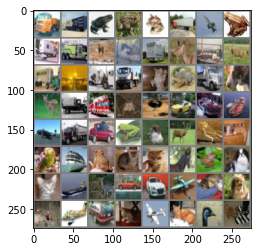

In [6]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

#### Transformer Encoder

In [7]:
class ScaledDotProductAttention(nn.Module):
    def __init_():
        super(ScaledDotProductAttention, self).__init_()
    
    def forward(self, Q, K, V):
        # K (batch_size, n_heads, len_k, d_k)
        # Q (batch_size, n_heads, len_q(=len_k), d_q(=d_k))
        # V (batch_size, n_heads, len_v(=len_k), d_v)
        d_k = K.shape[-1]
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k)
        # scores(batch_size, n_heads, len_q, len_k)
        # scores.masked_fill(attn_mask, -1e9)
        attn = F.softmax(scores, dim=-1)
        contexts = torch.matmul(attn, V)
        # contexts (batch_size, n_heads, len_v(=len_k), d_v)
        return contexts, attn

In [8]:
class MultHeadAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v, n_heads):
        super(MultHeadAttention, self).__init__()
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
        self.fc = nn.Linear(n_heads * d_v, d_model)
        self.layer_norm = nn.LayerNorm(d_model)
    
    def forward(self, Q, K, V):
        # K (batch_size, len_k, d_model)
        # Q (batch_size, len_q(=len_k), d_model)
        
        # V (batch_size, len_v(=len_k), d_model)
        residual, batch_size = Q, Q.shape[0]
        q = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        k = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        v = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1, 2)
        # attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)
        # attn_mask (batch_size, n_heads, len_k, len_q)
        context, attn = ScaledDotProductAttention()(q, k, v)
        # contexts (batch_size, n_heads, len_v(=len_k), d_v)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v)
        # contexts (batch_size, len_v(=len_k), n_heads * d_v)
        output = self.fc(context)
        # output (batch_size, len_v(=len_k), d_model)
        output = output + residual
        return self.layer_norm(output), attn


In [9]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.fc1 = nn.Linear(d_model, d_model)
        self.fc2 = nn.Linear(d_model, d_model)
        self.layer_norm = nn.LayerNorm(d_model)
    def forward(self, inputs):
        # inputs (batch_size, len_q, d_model)
        residual = inputs
        output = self.fc1(inputs)
        output = F.relu(output)
        output = self.fc2(output)
        return self.layer_norm(output + residual)

In [10]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_k, d_v, n_heads):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.enc_self_attn = MultHeadAttention(d_model, d_k, d_v, n_heads)
        self.pos_ffn = PoswiseFeedForwardNet(d_model)
    
    def forward(self, enc_inputs):
        # enc_inputs (batch_size, len_k, d_model)
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs)
        enc_outputs = self.pos_ffn(enc_outputs)
        # enc_outputs (batch_size, len_q, d_model)
        return enc_outputs, attn

In [11]:
class Encoder(nn.Module):
    def __init__(self, n, d_model, d_k, d_v, n_heads, n_layers):
        super(Encoder, self).__init__()
        # self.src_emb = nn.Embedding(n, d_model)
        # self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(n+1, d_model),freeze=True)
        self.n_layers = n_layers
        self.layers = nn.ModuleList([EncoderLayer(d_model,d_k, d_v, n_heads) for _ in range(n_layers)])
        # self.position = torch.LongTensor([[i for i in range(1, n+1)]]).to(device)
        self.position = nn.Parameter(torch.randn(1, n+1, d_model))
    def forward(self, enc_inputs):
        # enc_inputs (batch_size, h*w, patch_height*patch_width*in_channels)
        # enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(torch.LongTensor([[1,2,3,4,0]]))
        batch_size, n, _ = enc_inputs.shape
        # pos_emb_vec = self.pos_emb(self.position)
        enc_outputs = enc_inputs + self.position[:, :n]
        # enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

#### VGG16

In [12]:
class vgg_cell(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3,
                stride=1, padding=1, pool=False, kernel_size_pool=2,
                stride_pool=2, padding_pool=0):
        super(vgg_cell, self).__init__()
        self.net = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ])
        if pool:
            self.net.append(nn.MaxPool2d(kernel_size=kernel_size_pool,
                                         stride=stride_pool,
                                         padding=padding_pool))
        self.net = nn.Sequential(*self.net)
    def forward(self, x):
        # x: (batch_size, n_channels, h, w)
        x = self.net(x)
        return x

class vgg(nn.Module):
    def __init__(self, config, num_classes=10):
        super(vgg, self).__init__()
        self.num_classes = num_classes
        self.net = nn.ModuleList([])
        for in_channels, out_channels, kernel_size, stride, padding, pool in config:
            self.net.append(vgg_cell(in_channels=in_channels,
                                     out_channels=out_channels,
                                     kernel_size=kernel_size,
                                     stride=stride,
                                     padding=padding,
                                     pool=pool))
        # self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        # self.fc1 = nn.Linear(25088, 4096, bias=True)
        # self.fc2 = nn.Linear(4096, 4096, bias=True)
        # self.fc3 = nn.Linear(4096, 1000, bias=True)
        self.output_layer = nn.Linear(512, self.num_classes)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, mlp=True):
        batch_size = x.shape[0]
        for cell in self.net:
            x = cell(x)
        if mlp:
            x = x.view(batch_size, -1)
            x = self.output_layer(x)
        return x

#### ViT

In [13]:
class ViT(nn.Module):
    def __init__(self, image_size, in_channels, patch_size, num_classes, 
                 dim, depth, heads, mlp_dim, d_k=64, d_v=64, 
                 dropout=0, emb_dropout=0):
        super(ViT, self).__init__()
        image_height, image_width = image_size
        patch_height, patch_width = patch_size
        num_pathes = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = in_channels * patch_height * patch_width
        self.num_pathes = num_pathes
        self.patch_dim = patch_dim
        self.to_patch_layer = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
            nn.Linear(patch_dim, dim)
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Encoder(n=num_pathes+1,
                                    d_model=dim, 
                                    d_k=d_k, 
                                    d_v=d_v, 
                                    n_heads=heads, 
                                    n_layers=depth)
        # self.transformer_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads)
        # self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=depth, norm=nn.LayerNorm(dim))
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
    
    def forward(self, img):
        batch_size = img.shape[0]
        # img = img.view(batch_size, self.num_pathes, self.patch_dim)
        x = self.to_patch_layer(img)
        # cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=batch_size)
        # x = torch.cat((cls_tokens, x), dim=1)
        x = self.dropout(x)
        x, _ = self.transformer(x)
        x = x.mean(axis=1)
        x = self.mlp_head(x)
        return x

#### ViT FLOPs

In [22]:
def calc_vit_flops(vit_params, batch_size):
    in_channels = vit_params['in_channels']
    patch_height, patch_width = vit_params['patch_size']
    image_height, image_width = vit_params['image_size']
    num_pathes = (image_height // patch_height) * (image_width // patch_width)
    patch_dim = in_channels * patch_height * patch_width

    d_model = vit_params['dim']
    num_classes = vit_params['num_classes']
    d_k = vit_params['d_k']
    d_q = d_k
    d_v = vit_params['d_v']
    heads = vit_params['heads']
    depth = vit_params['depth']
    len_k, len_q, len_v = num_pathes, num_pathes, num_pathes

    '''
    batch_size * patch_dim * d_model +
    (拉平操作)

    (batch_size * d_model * heads * (len_k * d_k + len_q * d_q + len_v * d_v) + 
    (生成 key, query, value矩阵)

    batch_size * heads * len_q * d_k * len_k + 
    (使用key, query计算attention)

    batch_size * heads * len_q * len_k * d_v + batch_size * len_q * heads * d_v * d_model + 
    (使用attention, value计算 output)

    batch_size * len_q * d_model * d_model * 2) * depth + 
    (FeedForward)

    batch_size * d_model * num_classes
    (最终输出)
    '''

    FLOPs = batch_size * patch_dim * d_model + \
            (batch_size * d_model * heads * (len_k * d_k + len_q * d_q + len_v * d_v) + \
            batch_size * heads * len_q * d_k * len_k + \
            batch_size * heads * len_q * len_k * d_v + batch_size * len_q * heads * d_v * d_model + \
            batch_size * len_q * d_model * d_model * 2) * depth + \
            batch_size * d_model * num_classes

    return FLOPs

vit_params = {
            'image_size': (8, 8), 
            'in_channels': 128, 
            'patch_size': (1, 1), 
            'num_classes': 10, 
            'dim': 128, 
            'depth': 5, 
            'heads': 4,
            'mlp_dim': 128, 
            'd_k': 32,
            'd_v': 32, 
            'dropout': 0}
img = torch.randn(1, 128, 8, 8)
model_vit = ViT(**vit_params)
print(calc_vit_flops(vit_params, 1))
flops, params = profile(model_vit, inputs=(img, ))
print(flops, params)

36717824
[WARN] Cannot find rule for <class 'einops.layers.torch.Rearrange'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.normalization.LayerNorm'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.MultHeadAttention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.PoswiseFeedForwardNet'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.EncoderLayer'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Encoder'>. Treat it a

### Model A

In [54]:
class vgg_vit(nn.Module):
    def __init__(self, vgg_params, vit_params):
        super(vgg_vit, self).__init__()
        self.vgg = vgg(**vgg_params)
        self.vit = ViT(**vit_params)
    def forward(self, img):
        x = self.vgg(img, mlp=False)
        x = self.vit(x)
        return x

vgg_params ={
    'config': [
    (3, 64, 3, 1, 1, False),    #3 3
    (64, 64, 3, 1, 1, True),    #4 7
    (64, 128, 3, 1, 1, False),  #3 10
    (128, 128, 3, 1, 1, True),  #4 14
    # (128, 256, 3, 1, 1, False), #3 17
    # (256, 256, 3, 1, 1, False), #3 20
    # (256, 256, 3, 1, 1, True),  #4 24
    # (256, 512, 3, 1, 1, False), #3 27
    # (512, 512, 3, 1, 1, False), #3 30
    # (512, 512, 3, 1, 1, True),  #4 34
    # (512, 512, 3, 1, 1, False), #3 37
    # (512, 512, 3, 1, 1, False), #3 40
    # (512, 512, 3, 1, 1, True),  #4 44
    ], 
    'num_classes': 10
    }

vit_params = {
            'image_size': (8, 8), 
            'in_channels': 128, 
            'patch_size': (1, 1), 
            'num_classes': 10, 
            'dim': 128, 
            'depth': 5, 
            'heads': 4,
            'mlp_dim': 128, 
            'd_k': 32,
            'd_v': 32, 
            'dropout': 0}
'''
卷积层输入为(batch_size, 3, 32, 32)
卷积层输出为(batch_size, 128, 8, 8)
Transformer输入为(batch_size, 128, 8, 8) -> (batch_size, 64, 128)
'''
model_A = vgg_vit(vgg_params, vit_params).to(device)
model_vit = ViT(**vit_params).to(device)
model_vgg = vgg(**vgg_params).to(device)

训练模型

In [55]:
month = time.localtime().tm_mon
day = time.localtime().tm_mday
hour = time.localtime().tm_hour
minute = time.localtime().tm_min
img = torch.randn(1, 3, 32, 32).to(device)
loss = nn.CrossEntropyLoss()
optimizer_A = optim.Adam(model_A.parameters(), lr=1e-3, weight_decay=5e-5)
scheduler_A = optim.lr_scheduler.ExponentialLR(optimizer_A, gamma=0.9)
writer_A = SummaryWriter(log_dir=f'./logs/A/{month}-{day}-{hour}-{minute}', comment='A')
save_path = f'./logs/A/{month}-{day}-{hour}-{minute}/A.pth.tar'

model_A, train_accuracy, test_accuracy, lr_list = train_model(model_A, optimizer_A, loss, scheduler_A, num_epoches=50, verbose=1, writer=writer_A)

Epoch 00001 | Loss 1077.1991 | accuracy_train 0.4924 | accuracy_test 0.5384 | Time(s) 38.7019
Epoch 00002 | Loss 748.7860 | accuracy_train 0.6598 | accuracy_test 0.6553 | Time(s) 39.4481
Epoch 00003 | Loss 589.9284 | accuracy_train 0.7354 | accuracy_test 0.7296 | Time(s) 39.7012
Epoch 00004 | Loss 485.5783 | accuracy_train 0.7838 | accuracy_test 0.7702 | Time(s) 39.9253
Epoch 00005 | Loss 408.2453 | accuracy_train 0.8203 | accuracy_test 0.7864 | Time(s) 39.9819
Epoch 00006 | Loss 343.6498 | accuracy_train 0.8485 | accuracy_test 0.7947 | Time(s) 40.0566
Epoch 00007 | Loss 285.1344 | accuracy_train 0.8740 | accuracy_test 0.8109 | Time(s) 40.1558
Epoch 00008 | Loss 230.1602 | accuracy_train 0.8984 | accuracy_test 0.8083 | Time(s) 40.2654
Epoch 00009 | Loss 175.4440 | accuracy_train 0.9229 | accuracy_test 0.7964 | Time(s) 40.2250
Epoch 00010 | Loss 130.8740 | accuracy_train 0.9426 | accuracy_test 0.8118 | Time(s) 40.2847
Epoch 00011 | Loss 97.4980 | accuracy_train 0.9586 | accuracy_test 0.

保存模型

In [59]:
torch.save({'epoch': 50, 'optimizer_name':'Adam', 'learning_rate':1e-3, 'weight_decay':5e-5, 'optimizer_state_dict': optimizer_A.state_dict(), 'scheduler_state_dict':scheduler_A.state_dict(), 'model_state_dict': model_A.state_dict(), 'vgg_parameters':vgg_params, 'vit_parameters':vit_params}, save_path)

读取模型

In [123]:
ckpt_path = './logs/A/6-20-15-55/A.pth.tar'
CKPT = torch.load(ckpt_path)
model_A_CKPT = vgg_vit(CKPT['vgg_parameters'], CKPT['vit_parameters'])
model_A_CKPT.load_state_dict(CKPT['model_state_dict'])
model_A_CKPT.to(device)
accuracy_test= eval_test(model_A_CKPT, loss)
print(accuracy_test)

(0.8271, 197.76302981376648)


### Model B

In [95]:
class vgg_fc(nn.Module):
    def __init__(self, vgg_params):
        super(vgg_fc, self).__init__()
        self.vgg = vgg(**vgg_params)
        self.fc1 = nn.Linear(8192, 63)
        self.fc2 = nn.Linear(63, 10)
    def forward(self, img):
        batch_size = img.shape[0]
        x = self.vgg(img, mlp=False)
        x = x.view(batch_size, -1)
        x = self.fc2(self.fc1(x))
        return x

vgg_params ={
    'config': [
    (3, 64, 3, 1, 1, False),    #3 3
    (64, 64, 3, 1, 1, True),    #4 7
    (64, 128, 3, 1, 1, False),  #3 10
    (128, 128, 3, 1, 1, True),  #4 14
    # (128, 256, 3, 1, 1, False), #3 17
    # (256, 256, 3, 1, 1, False), #3 20
    # (256, 256, 3, 1, 1, True),  #4 24
    # (256, 512, 3, 1, 1, False), #3 27
    # (512, 512, 3, 1, 1, False), #3 30
    # (512, 512, 3, 1, 1, True),  #4 34
    # (512, 512, 3, 1, 1, False), #3 37
    # (512, 512, 3, 1, 1, False), #3 40
    # (512, 512, 3, 1, 1, True),  #4 44
    ], 
    'num_classes': 10
    }
model_B = vgg_fc(vgg_params).to(device)

训练模型

In [96]:
month = time.localtime().tm_mon
day = time.localtime().tm_mday
hour = time.localtime().tm_hour
minute = time.localtime().tm_min
img = torch.randn(1, 3, 32, 32).to(device)
loss = nn.CrossEntropyLoss()
optimizer_B = optim.Adam(model_B.parameters(), lr=1e-3, weight_decay=5e-5)
scheduler_B = optim.lr_scheduler.ExponentialLR(optimizer_B, gamma=0.9)
writer_B = SummaryWriter(log_dir=f'./logs/B/{month}-{day}-{hour}-{minute}', comment='B')
save_path = f'./logs/B/{month}-{day}-{hour}-{minute}/B.pth.tar'

model_B, train_accuracy, test_accuracy, lr_list = train_model(model_B, optimizer_B, loss, scheduler_B, num_epoches=50, verbose=1, writer=writer_B)

Epoch 00001 | Loss 1118.4519 | accuracy_train 0.5135 | accuracy_test 0.6290 | Time(s) 21.3221
Epoch 00002 | Loss 674.9079 | accuracy_train 0.6983 | accuracy_test 0.7099 | Time(s) 20.8915
Epoch 00003 | Loss 530.3260 | accuracy_train 0.7633 | accuracy_test 0.7573 | Time(s) 20.9120
Epoch 00004 | Loss 430.2576 | accuracy_train 0.8081 | accuracy_test 0.7388 | Time(s) 21.3560
Epoch 00005 | Loss 349.3073 | accuracy_train 0.8448 | accuracy_test 0.7883 | Time(s) 21.3632
Epoch 00006 | Loss 262.2636 | accuracy_train 0.8825 | accuracy_test 0.7941 | Time(s) 21.3923
Epoch 00007 | Loss 192.4597 | accuracy_train 0.9139 | accuracy_test 0.7950 | Time(s) 21.5155
Epoch 00008 | Loss 134.0794 | accuracy_train 0.9406 | accuracy_test 0.7804 | Time(s) 21.5142
Epoch 00009 | Loss 83.5579 | accuracy_train 0.9632 | accuracy_test 0.7902 | Time(s) 21.5536
Epoch 00010 | Loss 55.6184 | accuracy_train 0.9759 | accuracy_test 0.7856 | Time(s) 21.5541
Epoch 00011 | Loss 35.9937 | accuracy_train 0.9847 | accuracy_test 0.79

保存模型

In [98]:
torch.save({'epoch': 50, 'optimizer_name':'Adam', 'learning_rate':1e-3, 'weight_decay':5e-5, 'optimizer_state_dict': optimizer_B.state_dict(), 'scheduler_state_dict':scheduler_B.state_dict(), 'model_state_dict': model_B.state_dict(), 'vgg_parameters':vgg_params}, save_path)

读取模型

In [99]:
ckpt_path = './logs/B/6-20-18-11/B.pth.tar'
CKPT = torch.load(ckpt_path)
model_B_CKPT = vgg_fc(CKPT['vgg_parameters'])
model_B_CKPT.load_state_dict(CKPT['model_state_dict'])
model_B_CKPT.to(device)
accuracy_test= eval_test(model_B_CKPT, loss)
print(accuracy_test)

(0.7985, 234.34924456477165)


Text(0.5, 1.0, 'Learning Rate Decay')

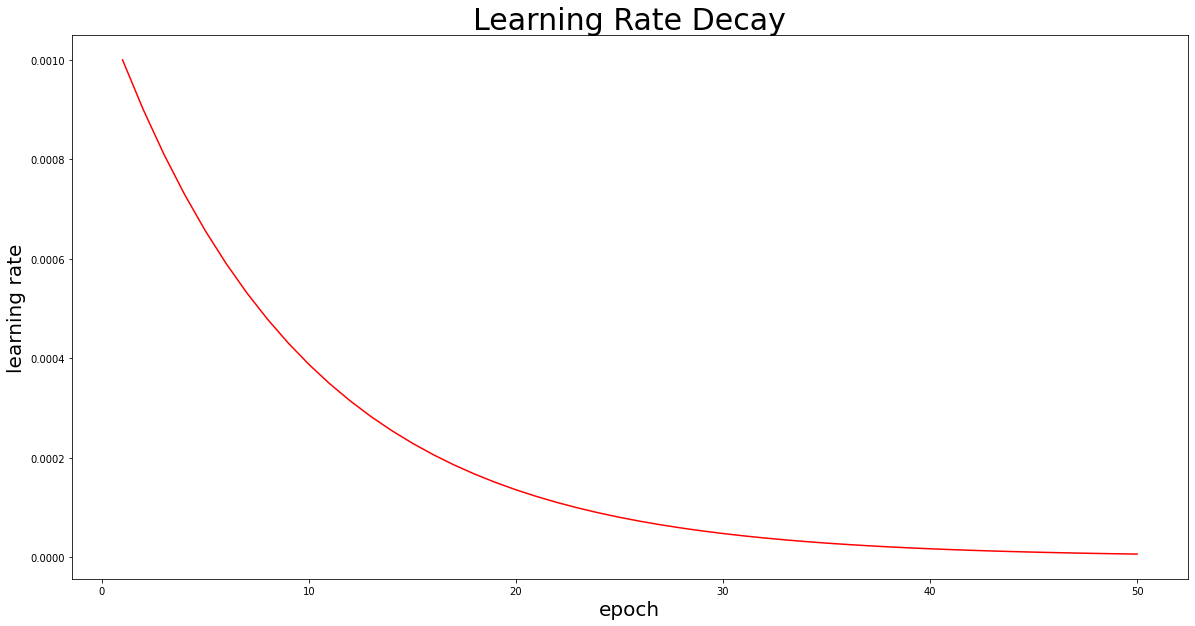

In [107]:
plt.figure(figsize=(20, 10))
plt.plot(list(range(1, 51)), lr_list, color = 'r')
plt.xlabel('epoch', fontsize=20)
plt.ylabel('learning rate', fontsize=20)
plt.title('Learning Rate Decay', fontsize=30)

### Model C

In [108]:
class vgg_fc_FLOPs(nn.Module):
    def __init__(self, vgg_params):
        super(vgg_fc_FLOPs, self).__init__()
        self.vgg = vgg(**vgg_params)
        self.fc1 = nn.Linear(8192, 4096)
        self.fc2 = nn.Linear(4096, 768)
        self.fc3 = nn.Linear(768, 10)
    def forward(self, img):
        batch_size = img.shape[0]
        x = self.vgg(img, mlp=False)
        x = x.view(batch_size, -1)
        x = self.fc3(self.fc2(self.fc1(x)))
        return x

vgg_params ={
    'config': [
    (3, 64, 3, 1, 1, False),    #3 3
    (64, 64, 3, 1, 1, True),    #4 7
    (64, 128, 3, 1, 1, False),  #3 10
    (128, 128, 3, 1, 1, True),  #4 14
    # (128, 256, 3, 1, 1, False), #3 17
    # (256, 256, 3, 1, 1, False), #3 20
    # (256, 256, 3, 1, 1, True),  #4 24
    # (256, 512, 3, 1, 1, False), #3 27
    # (512, 512, 3, 1, 1, False), #3 30
    # (512, 512, 3, 1, 1, True),  #4 34
    # (512, 512, 3, 1, 1, False), #3 37
    # (512, 512, 3, 1, 1, False), #3 40
    # (512, 512, 3, 1, 1, True),  #4 44
    ], 
    'num_classes': 10
    }
model_C = vgg_fc_FLOPs(vgg_params).to(device)

训练模型

In [109]:
month = time.localtime().tm_mon
day = time.localtime().tm_mday
hour = time.localtime().tm_hour
minute = time.localtime().tm_min
img = torch.randn(1, 3, 32, 32).to(device)
loss = nn.CrossEntropyLoss()
optimizer_C = optim.Adam(model_C.parameters(), lr=1e-3, weight_decay=5e-5)
scheduler_C = optim.lr_scheduler.ExponentialLR(optimizer_C, gamma=0.9)
writer_C = SummaryWriter(log_dir=f'./logs/C/{month}-{day}-{hour}-{minute}', comment='C')
save_path = f'./logs/C/{month}-{day}-{hour}-{minute}/C.pth.tar'

model_C, train_accuracy, test_accuracy, lr_list = train_model(model_C, optimizer_C, loss, scheduler_C, num_epoches=50, verbose=1, writer=writer_C)

Epoch 00001 | Loss 2747.7295 | accuracy_train 0.3735 | accuracy_test 0.4956 | Time(s) 40.0837
Epoch 00002 | Loss 911.0199 | accuracy_train 0.5833 | accuracy_test 0.6446 | Time(s) 40.9416
Epoch 00003 | Loss 709.1735 | accuracy_train 0.6784 | accuracy_test 0.6908 | Time(s) 41.6650
Epoch 00004 | Loss 578.4386 | accuracy_train 0.7406 | accuracy_test 0.7212 | Time(s) 41.7401
Epoch 00005 | Loss 489.7818 | accuracy_train 0.7806 | accuracy_test 0.7383 | Time(s) 41.9575
Epoch 00006 | Loss 418.9750 | accuracy_train 0.8129 | accuracy_test 0.7553 | Time(s) 42.0999
Epoch 00007 | Loss 344.5471 | accuracy_train 0.8442 | accuracy_test 0.7576 | Time(s) 42.1871
Epoch 00008 | Loss 277.3686 | accuracy_train 0.8728 | accuracy_test 0.7638 | Time(s) 42.4456
Epoch 00009 | Loss 207.5839 | accuracy_train 0.9052 | accuracy_test 0.7621 | Time(s) 42.5356
Epoch 00010 | Loss 144.8837 | accuracy_train 0.9346 | accuracy_test 0.7489 | Time(s) 42.6256
Epoch 00011 | Loss 100.6341 | accuracy_train 0.9533 | accuracy_test 0

保存模型

In [110]:
torch.save({'epoch': 100, 'optimizer_name':'Adam', 'learning_rate':1e-3, 'weight_decay':5e-5, 'optimizer_state_dict': optimizer_C.state_dict(), 'scheduler_state_dict':scheduler_C.state_dict(), 'model_state_dict': model_C.state_dict(), 'vgg_parameters':vgg_params}, save_path)

读取模型

In [112]:
ckpt_path = './logs/C/6-20-18-40/C.pth.tar'
CKPT = torch.load(ckpt_path)
model_C_CKPT = vgg_fc_FLOPs(CKPT['vgg_parameters'])
model_C_CKPT.load_state_dict(CKPT['model_state_dict'])
model_C_CKPT.to(device)
accuracy_test= eval_test(model_C_CKPT, loss)
print(accuracy_test)

(0.7778, 270.26973408460617)


### 计算参数量 & FLOPs

In [133]:
img = torch.randn(1, 3, 32, 32).to(device)
vgg_flops, vgg_params_num = profile(model_vgg, inputs=(img, False))
vit_flops = calc_vit_flops(vit_params, 1)
model_A_flops = vgg_flops + vit_flops
_, model_A_params_num = profile(model_A, inputs=(img, ))
print('Model A Params Num: ', model_A_params_num)
print('Model A FLOPS: ', model_A_flops)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.vgg_cell'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.vgg'>. Treat it as zero Macs and zero Params.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 't

In [134]:
img = torch.randn(1, 3, 32, 32).to(device)
model_B_flops, model_B_params_num = profile(model_B, inputs=(img, ))
print('Model B Params Num: ', model_B_params_num)
print('Model B FLOPS: ', model_B_flops)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.vgg_cell'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.vgg'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.vgg_fc'>. Treat it as zero Macs and zero Params.
Model B Params Num:  777727.0
Model B FLOPS:  97247862.0


In [135]:
img = torch.randn(1, 3, 32, 32).to(device)
model_C_flops, model_C_params_num = profile(model_C, inputs=(img, ))
print('Model C Params Num: ', model_C_params_num)
print('Model C FLOPS: ', model_C_flops)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.vgg_cell'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.vgg'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.vgg_fc_FLOPs'>. Treat it as zero Macs and zero Params.
Model C Params Num:  36973642.0
Model C FLOPS:  133438976.0


In [46]:
print('Model A Params Num: ', model_A_params_num)
print('Model B Params Num: ', model_B_params_num)

Model A Params Num:  774090.0
Model B Params Num:  777727.0


In [48]:
print('Model A FLOPS: ', model_A_flops)
print('Model C FLOPS: ', model_C_flops)

Model A FLOPS:  133448960.0
Model C FLOPS:  133438976.0


### 模型评价

In [113]:
y_test = []
for X, y in testset:
    y_test.append(y)
y_test = np.eye(10)[y_test]

In [114]:
y_test_pred_A = []
y_test_pred_proba_A = []
for X, y in testset:
    X = X.unsqueeze(0).to(device)
    pred_proba_tmp = F.softmax(model_A_CKPT(X), dim=1)
    pred_tmp = torch.argmax(pred_proba_tmp, axis=1).cpu().detach().numpy()
    y_test_pred_proba_A.append(pred_proba_tmp.cpu().detach().numpy()[0].tolist())
    y_test_pred_A.append(pred_tmp[0])
y_test_pred_A = np.eye(10)[y_test_pred_A]

In [115]:
y_test_pred_B = []
y_test_pred_proba_B = []
for X, y in testset:
    X = X.unsqueeze(0).to(device)
    pred_proba_tmp = F.softmax(model_B_CKPT(X), dim=1)
    pred_tmp = torch.argmax(pred_proba_tmp, axis=1).cpu().detach().numpy()
    y_test_pred_proba_B.append(pred_proba_tmp.cpu().detach().numpy()[0].tolist())
    y_test_pred_B.append(pred_tmp[0])
y_test_pred_B = np.eye(10)[y_test_pred_B]

In [116]:
y_test_pred_C = []
y_test_pred_proba_C = []
for X, y in testset:
    X = X.unsqueeze(0).to(device)
    pred_proba_tmp = F.softmax(model_C_CKPT(X), dim=1)
    pred_tmp = torch.argmax(pred_proba_tmp, axis=1).cpu().detach().numpy()
    y_test_pred_proba_C.append(pred_proba_tmp.cpu().detach().numpy()[0].tolist())
    y_test_pred_C.append(pred_tmp[0])
y_test_pred_C = np.eye(10)[y_test_pred_C] 

In [117]:
micro_auc_A = roc_auc_score(y_test, y_test_pred_proba_A, average='micro')
macro_auc_A = roc_auc_score(y_test, y_test_pred_proba_A, average='macro')
micro_precision_A = precision_score(y_test, y_test_pred_A, average='micro')
macro_precision_A = precision_score(y_test, y_test_pred_A, average='macro')
micro_recall_A = recall_score(y_test, y_test_pred_A, average='micro')
macro_recall_A = recall_score(y_test, y_test_pred_A, average='macro')
print('AUC', micro_auc_A, macro_auc_A)
print('Precision', micro_precision_A, macro_precision_A)
print('Recall', micro_recall_A, macro_recall_A)

AUC 0.9752548 0.9753324222222222
Precision 0.8271 0.8264045446442729
Recall 0.8271 0.8271000000000001


In [118]:
micro_auc_B = roc_auc_score(y_test, y_test_pred_proba_B, average='micro')
macro_auc_B = roc_auc_score(y_test, y_test_pred_proba_B, average='macro')
micro_precision_B = precision_score(y_test, y_test_pred_B, average='micro')
macro_precision_B = precision_score(y_test, y_test_pred_B, average='macro')
micro_recall_B = recall_score(y_test, y_test_pred_B, average='micro')
macro_recall_B = recall_score(y_test, y_test_pred_B, average='macro')
print('AUC', micro_auc_B, macro_auc_B)
print('Precision', micro_precision_B, macro_precision_B)
print('Recall', micro_recall_B, macro_recall_B)

AUC 0.9791378733333334 0.9769344777777776
Precision 0.7985 0.7991147106213436
Recall 0.7985 0.7985


In [119]:
micro_auc_C = roc_auc_score(y_test, y_test_pred_proba_C, average='micro')
macro_auc_C = roc_auc_score(y_test, y_test_pred_proba_C, average='macro')
micro_precision_C = precision_score(y_test, y_test_pred_C, average='micro')
macro_precision_C = precision_score(y_test, y_test_pred_C, average='macro')
micro_recall_C = recall_score(y_test, y_test_pred_C, average='micro')
macro_recall_C = recall_score(y_test, y_test_pred_C, average='macro')
print('AUC', micro_auc_C, macro_auc_C)
print('Precision', micro_precision_C, macro_precision_C)
print('Recall', micro_recall_C, macro_recall_C)

AUC 0.9718308399999999 0.9700831166666667
Precision 0.7778 0.7772968843009906
Recall 0.7778 0.7778


In [120]:
num_class = 10
fpr = {'A':{}, 'B':{}, 'C':{}}
tpr = {'A':{}, 'B':{}, 'C':{}}
roc_auc = {'A':{}, 'B':{}, 'C':{}}
for model_name in ['A', 'B', 'C']:
    for i in range(num_class):
        fpr[model_name][i], tpr[model_name][i], _ = roc_curve(y_test[:, i], np.array(eval(f'y_test_pred_proba_{model_name}'))[:, i])
        roc_auc[model_name][i] = auc(fpr[model_name][i], tpr[model_name][i])
    
    fpr[model_name]["micro"], tpr[model_name]["micro"], _ = roc_curve(y_test.ravel(), np.array(eval(f'y_test_pred_proba_{model_name}')).ravel())
    roc_auc[model_name]["micro"] = auc(fpr[model_name]["micro"], tpr[model_name]["micro"])

    all_fpr = np.unique(np.concatenate([fpr[model_name][i] for i in range(num_class)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_class):
        mean_tpr += interp(all_fpr, fpr[model_name][i], tpr[model_name][i])

    # Finally average it and compute AUC
    mean_tpr /= num_class

    fpr[model_name]["macro"] = all_fpr
    tpr[model_name]["macro"] = mean_tpr
    roc_auc[model_name]["macro"] = auc(fpr[model_name]["macro"], tpr[model_name]["macro"])

ipykernel_launcher:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


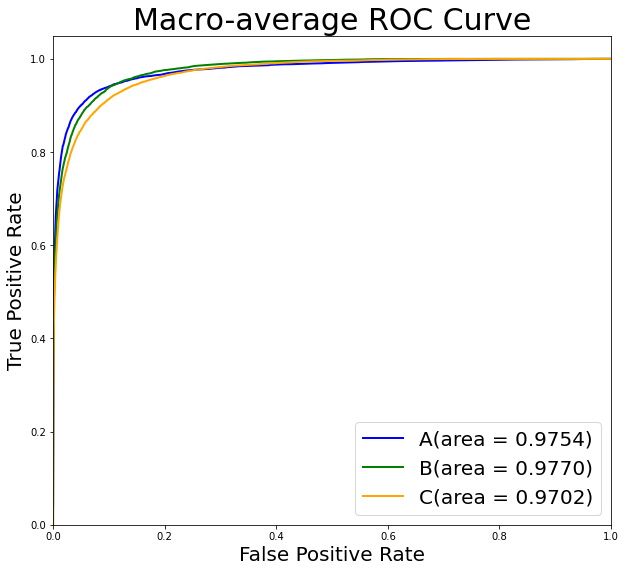

In [121]:
plt.figure(figsize=[10, 9])
lw = 2
colors = ['blue', 'green', 'orange']
for ind, model_name in enumerate(['A', 'B', 'C']):
    plt.plot(fpr[model_name]["macro"], tpr[model_name]["macro"], color=colors[ind],
            lw=lw, label=f'{model_name}(area = %0.4f)' % roc_auc[model_name]['macro'])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Macro-average ROC Curve', fontsize=30)
plt.legend(loc="lower right", fontsize=20)
plt.savefig('macro_auc.png')
plt.show()

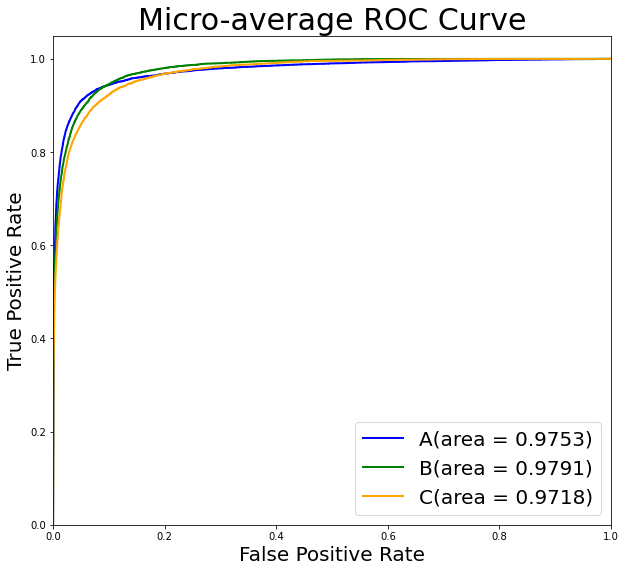

In [122]:
plt.figure(figsize=[10, 9])
lw = 2
colors = ['blue', 'green', 'orange']
for ind, model_name in enumerate(['A', 'B', 'C']):
    plt.plot(fpr[model_name]["micro"], tpr[model_name]["micro"], color=colors[ind],
            lw=lw, label=f'{model_name}(area = %0.4f)' % roc_auc[model_name]['micro'])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Micro-average ROC Curve', fontsize=30)
plt.legend(loc="lower right", fontsize=20)
plt.savefig('micro_auc.png')
plt.show()

In [125]:
y_test_label = np.where(y_test==1)[1]
y_test_pred_label_A = np.where(y_test_pred_A==1)[1]
y_test_pred_label_B = np.where(y_test_pred_B==1)[1]
y_test_pred_label_C = np.where(y_test_pred_C==1)[1]

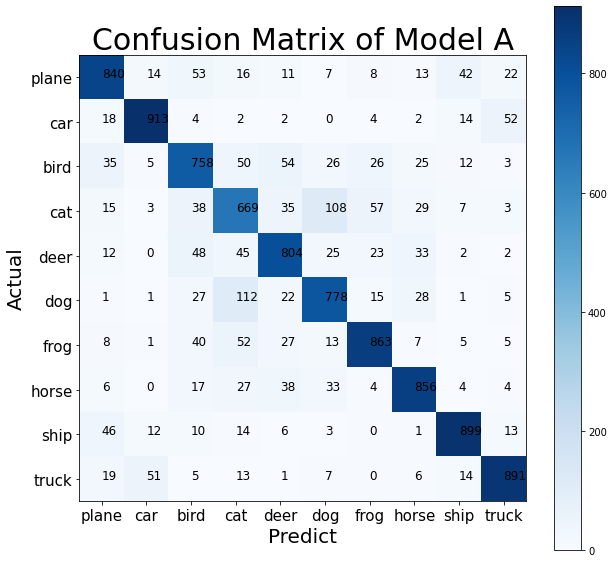

In [130]:
# y_test_label_class = [classes[x] for x in y_test_label]
# y_test_pred_label_A_class = [classes[x] for x in y_test_pred_label_A]
confusion_mat_A = confusion_matrix(y_test_label, y_test_pred_label_A)
plt.figure(figsize=[10, 10])
plt.imshow(confusion_mat_A, cmap=plt.cm.Blues)
indices = range(len(confusion_mat_A))
plt.xticks(indices, classes, fontsize=15)
plt.yticks(indices, classes, fontsize=15)
plt.colorbar()
plt.title('Confusion Matrix of Model A', fontsize=30)
plt.xlabel('Predict', fontsize=20)
plt.ylabel('Actual', fontsize=20)
for first_index in range(len(confusion_mat_A)):
    for second_index in range(len(confusion_mat_A[first_index])):
        plt.text(first_index, second_index, confusion_mat_A[first_index][second_index], fontsize=12)
plt.savefig('confusion matrix A.png')
plt.show()

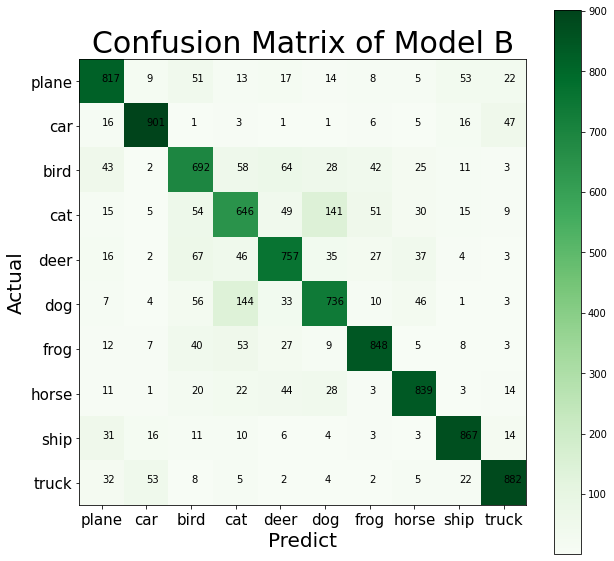

In [131]:
confusion_mat_B = confusion_matrix(y_test_label, y_test_pred_label_B)
plt.figure(figsize=[10, 10])
plt.imshow(confusion_mat_B, cmap=plt.cm.Greens)
indices = range(len(confusion_mat_B))
plt.xticks(indices, classes, fontsize=15)
plt.yticks(indices, classes, fontsize=15)
plt.colorbar()
plt.title('Confusion Matrix of Model B', fontsize=30)
plt.xlabel('Predict', fontsize=20)
plt.ylabel('Actual', fontsize=20)
for first_index in range(len(confusion_mat_B)):
    for second_index in range(len(confusion_mat_B[first_index])):
        plt.text(first_index, second_index, confusion_mat_B[first_index][second_index])
plt.savefig('confusion matrix B.png')
plt.show()

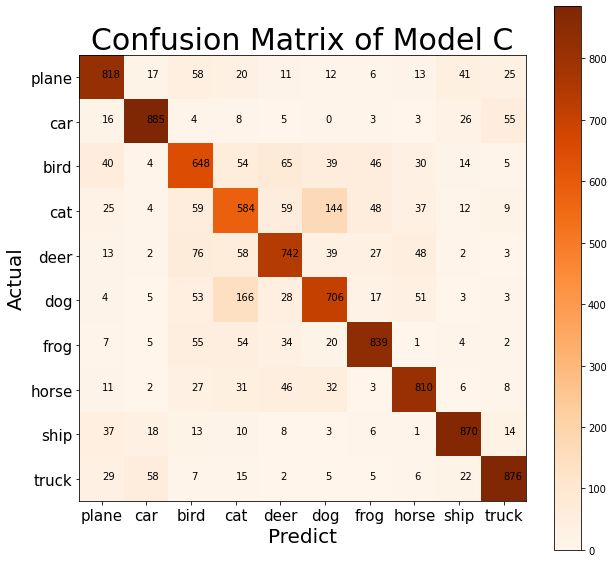

In [132]:
confusion_mat_C = confusion_matrix(y_test_label, y_test_pred_label_C)
plt.figure(figsize=[10, 10])
plt.imshow(confusion_mat_C, cmap=plt.cm.Oranges)
indices = range(len(confusion_mat_C))
plt.xticks(indices, classes, fontsize=15)
plt.yticks(indices, classes, fontsize=15)
plt.colorbar()
plt.title('Confusion Matrix of Model C', fontsize=30)
plt.xlabel('Predict', fontsize=20)
plt.ylabel('Actual', fontsize=20)
for first_index in range(len(confusion_mat_C)):
    for second_index in range(len(confusion_mat_C[first_index])):
        plt.text(first_index, second_index, confusion_mat_C[first_index][second_index])
plt.savefig('confusion matrix C.png')
plt.show()

In [263]:
y_test_label

array([3, 8, 8, ..., 5, 1, 7], dtype=int64)

In [264]:
y_test_pred_A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])